In [126]:
#Import all the needed libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse
import copy

In [127]:
# Insert all functions from py helper functions
####################################################
# Import packages
####################################################
import numpy as np
import copy
import pandas as pd
from plotnine import *


####################################################
# Define global vars
####################################################
color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]


####################################################
# Define helper functions
####################################################
def seq(start, stop, by, round_n=3):
    return [round(x, round_n) for x in list(np.arange(start, stop, by))]


def skew(l, round_n=3):
    return round((np.mean(l) - np.median(l)) / np.std(l), round_n)


def lspline(series, knots):
    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix

def create_calibration_plot(
    data,
    file_name,
    prob_var,
    actual_var,
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    if breaks is None:
        breaks = np.around(
            np.linspace(0, (n_bins + 1) / 10, num=n_bins + 1, endpoint=False),
            decimals=1,
        ).tolist()

    data["prob_bin"] = pd.cut(data[prob_var], breaks, right=True, include_lowest=True)

    binned_data = (
        data.groupby("prob_bin")
        .agg(
            mean_prob=(prob_var, "mean"),
            mean_actual=(actual_var, "mean"),
            n=(actual_var, "size"),
        )
        .reset_index()
    )

    plot = (
        ggplot(binned_data, aes("mean_prob", "mean_actual"))
        + geom_line(color=color[0], size=1, show_legend=True)
        + geom_point(
            color=color[0],
            size=1,
            alpha=0.7,
            show_legend=False,
            na_rm=True,
        )
        + geom_segment(
            x=min(breaks),
            xend=max(breaks),
            y=min(breaks),
            yend=max(breaks),
            color=color[1],
            size=0.5,
        )
        + theme_bw()
        + labs(x="Predicted event probability", y=y_lab)
        + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
        + expand_limits(x=0.01, y=0.01)
        + scale_y_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
        + scale_x_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
    )

    return plot


In [128]:
#Current working directory
current_path = os.getcwd()
current_path

'C:\\Users\\Имя\\predictions_hw1'

In [129]:
#Give a new path
os.chdir('C:\\Users\\Имя\\predictions_hw1')


In [130]:
dirname = os.getcwd()
data_in = dirname + "da_data_repo/cps-earnings/clean/"


In [131]:
#PART I
#Import the data
data = pd.read_csv('morg-2014-emp.csv')
data.head()#take a look at the data

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


In [132]:
#Filter the data in a way that I only have doctor's occupations. Excluded: pharmacists; nurses; variables including "all other";
# veterinarians, opticions, technologists and technicians
df = data.loc[data.occ2012.isin([3000, 3010, 3030, 3040, 3060, 3140, 3150, 3160, 3200, 3210, 3220])]

df.head() #check how this new data set looks like
len(df.columns) #check whether it has same number of columns

23

In [133]:
#Check missing values: need it before i will create dummy not to make a mistake
df.isna().sum() #no missing values in variables of interest

Unnamed: 0       0
hhid             0
intmonth         0
stfips           0
weight           0
earnwke          0
uhours           0
grade92          0
race             0
ethnic        1609
age              0
sex              0
marital          0
ownchild         0
chldpres         0
prcitshp         0
state            0
ind02            0
occ2012          0
class            0
unionmme         0
unioncov       115
lfsr94           0
dtype: int64

In [134]:
# Create new variables
df["female"] = (df.sex == 2).astype(int) #transform sex variable in easier to use and read dummy variable
df["wage"] = df["earnwke"] / df["uhours"] #variable for hourly wage
df["lnwage"] = np.log(df["wage"]) # I need a log of hours wage
df["agesq"] = np.power(df["age"], 2) # variable for age squared since I want to test the quadratic relationship between ln hourly wage and wage
df["fem_age"] = df['female'] * df['age'] # including interaction to test whether gender differential varies by age
 
df['citizen'] = df.prcitshp.apply(lambda x: 1 if x != "Foreign Born, Not a US Citizen" else 0)#dummy to account that some doctors are officialy citizens (1 = citizen)
df['spouce'] = df.marital.apply(lambda x: 1 if x <= 2 else 0) # create dummy 1 - if spouce is married and present, 0 otherwise
df['atwork'] = df.lfsr94.apply(lambda x: 1 if x == "Employed-At Work" else 0) # 1 - emp at work, 0 - emp, absent
df['private'] = df["class"].apply(lambda x: 1 if x == 'Private, For Profit' or x == 'Private, Nonprofit' else 0) 


In [135]:
#I suspect that those who are employed but not at work might be significantly different from those who are at work right now
# Moreover, I don't know for what reasons they are not at work (pregnancy might be one, but might be smth else)
# So, I drop all the employed-absent variables from data set
df = df[df.atwork != 0] #drop those absent at work
df.atwork.describe() #check whether it is what I wanted now

count    1629.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: atwork, dtype: float64

In [136]:
#Sample data set only to variables of interest
list(df.columns) #look at all the names of columns

['Unnamed: 0',
 'hhid',
 'intmonth',
 'stfips',
 'weight',
 'earnwke',
 'uhours',
 'grade92',
 'race',
 'ethnic',
 'age',
 'sex',
 'marital',
 'ownchild',
 'chldpres',
 'prcitshp',
 'state',
 'ind02',
 'occ2012',
 'class',
 'unionmme',
 'unioncov',
 'lfsr94',
 'female',
 'wage',
 'lnwage',
 'agesq',
 'fem_age',
 'citizen',
 'spouce',
 'atwork',
 'private']

In [137]:
# Select columns which are of interest
df_final = df[['hhid', 'wage','grade92', 'age','agesq', 'ownchild', 'occ2012', 'private','female','lnwage','fem_age','citizen',
              'spouce', 'atwork' ]]

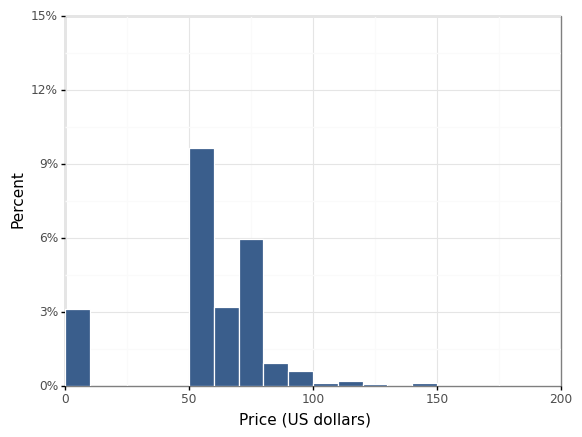

<ggplot: (156956668377)>

In [138]:
# Check the distribution on wage and ln wage to justify using of ln
def seq(start, stop, by, round_n=3):
    return [round(x, round_n) for x in list(np.arange(start, stop, by))]

(
    ggplot(df_final, aes(x="wage"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=10,
        fill="#3a5e8cFF",
        color="white",
        alpha=0.8,
        boundary=0,
        closed="left",
    )
    + labs(x="Price (US dollars)", y="Percent")
    + scale_y_continuous(
        expand=(0.00, 0.00),
        limits=(0, 0.15),
        breaks=seq(0, 0.16, by=0.03),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=(0.00, 0.00), limits=(0, 200), breaks=seq(0, 401, 50))
    + theme_bw()
)

In [139]:
# I see quite a strange distribution, so I want to check what is it on the left hand. Are these people too different from others
(df_final.wage == 0).sum() #look whether anyone earns 0, i get that none - good



0

In [140]:
#Okay then let's creat a subsample and look in more detail
df_new = df_final[df_final.wage < 50]
df_new.describe()
df_new.head(50) # there is a variety of occupaiton codes in this data set, they are from both government and private sector
df_new.wage.mean() # the mean is 28 dollars
#Overall I didn't see any abnormal characteristics in those who earn less than 50, so I decided to keep them

28.199079167331863

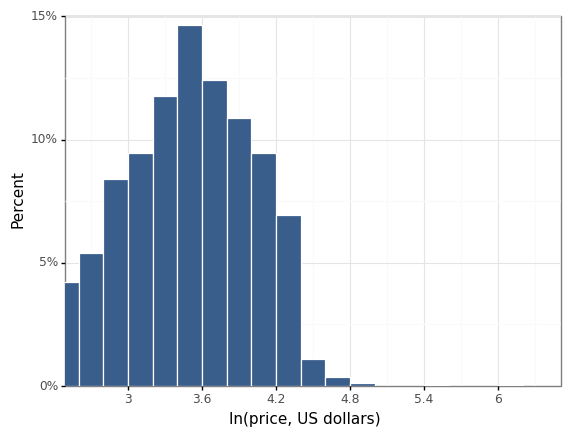

<ggplot: (156956659188)>

In [141]:
#Now plot lnwage
(
    ggplot(df_final, aes(x="lnwage"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=0.2,
        fill=color[0],
        color="white",
        alpha=0.8,
        boundary=0,
        closed="left",
    )
    + coord_cartesian(xlim=(2.5, 6.5))
    + scale_y_continuous(
        expand=(0.00, 0.00),
        limits=(0, 0.15),
        breaks=seq(0, 0.16, by=0.05),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=(0.00, 0.01), breaks=seq(2.4, 6.7, 0.6))
    + labs(x="ln(price, US dollars)", y="Percent")
    + theme_bw()
)
# It looks much more like a normal distribution - use of ln version is justified

In [142]:
#Save this data to csv (and don't touch it) to have it as starting point for regression analysis
df_final.to_csv('doctors_wage.csv', index=False)

In [187]:
# Part 2
# First define functions to evaluate interactions later
# Important! I am using here wage even though for reasons described above I will use lnwage
# Here it is done only for variable selection purposes

def price_diff_by_variables(df, factor_var, dummy_var):
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("wage", np.mean), sd=("wage", np.std), size=("wage", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + ylab("Mean wage")
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
        )
        + scale_fill_grey()
    )

    return plot

def price_diff_by_variables2(df, factor_var, dummy_var, factor_lab, dummy_lab):
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("wage", np.mean), sd=("wage", np.std), size=("wage", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + scale_color_manual(name=dummy_lab, values=(color[1], color[0]))
        + scale_fill_manual(name=dummy_lab, values=(color[1], color[0]))
        + ylab("Mean wage")
        + xlab(factor_lab)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position="top",
            legend_box="vertical",
            legend_text=element_text(size=5),
            legend_title=element_text(size=5, face="bold"),
        )
    )

    return plot


In [188]:
# Just look at all variables again
list(df_final.columns)

['hhid',
 'wage',
 'grade92',
 'age',
 'agesq',
 'occ2012',
 'private',
 'female',
 'lnwage',
 'fem_age',
 'citizen',
 'spouce',
 'children']

In [189]:
# Drop variables that I don't need
df_final = df_final.drop('atwork',axis = 1)

KeyError: "['atwork'] not found in axis"

In [190]:
df_final.ownchild.describe()# look how ownchild is distributed in data set
# Based on reading literature, I decided to use dummy variable for children instead of number of children
df_final['children'] = df_final.ownchild.apply(lambda x: 1 if x >0 else 0) # 1 - has children
df_final.children.describe()#look whether I have what I want
df_final = df_final.drop('ownchild',axis = 1) #drop ownchildren


AttributeError: 'DataFrame' object has no attribute 'ownchild'

In [191]:
list(df_final.columns) #check that is what I want

['hhid',
 'wage',
 'grade92',
 'age',
 'agesq',
 'occ2012',
 'private',
 'female',
 'lnwage',
 'fem_age',
 'citizen',
 'spouce',
 'children']

In [192]:
# Interactions are based on domain knowldge
# 1 - female*spouce
# 2 - female*citizen
# 3 - private*citizen
# 4 - female*children

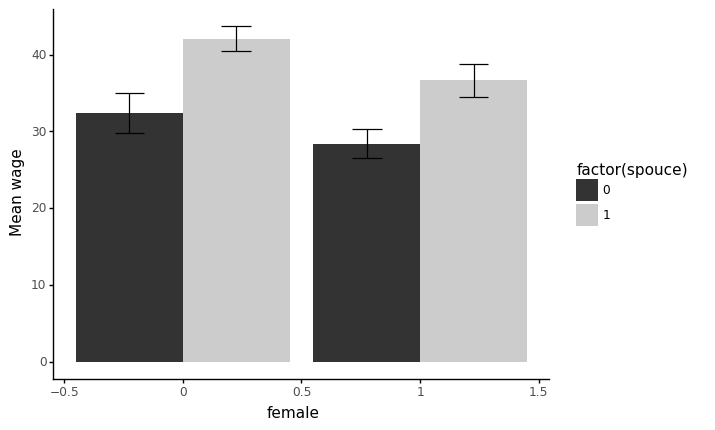

<ggplot: (156956686815)>

In [193]:
# Interaction 1 - female*spouce
price_diff_by_variables(df_final,"female","spouce")

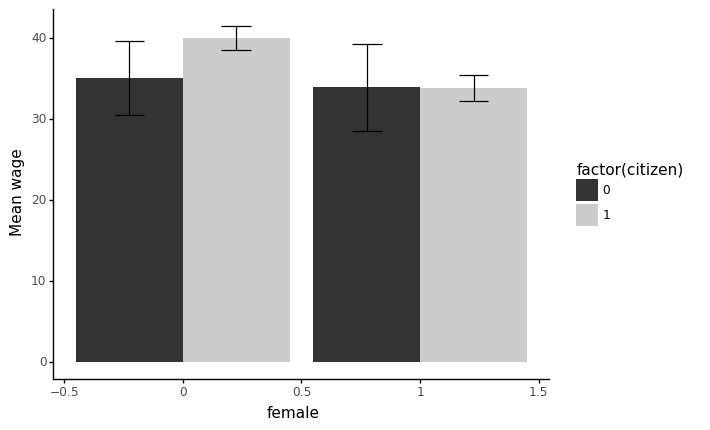

<ggplot: (156956866910)>

In [194]:
# Interaction 2 - female*citizen
price_diff_by_variables(df_final,"female","citizen")

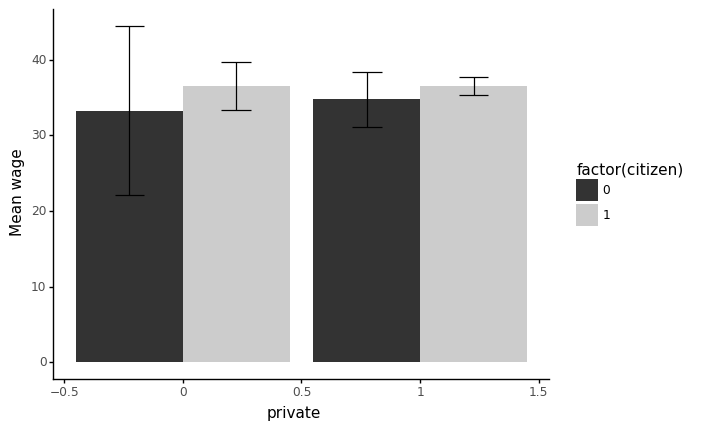

<ggplot: (156956920634)>

In [195]:
# Interaction 3 - private*citizen
price_diff_by_variables(df_final,"private","citizen")

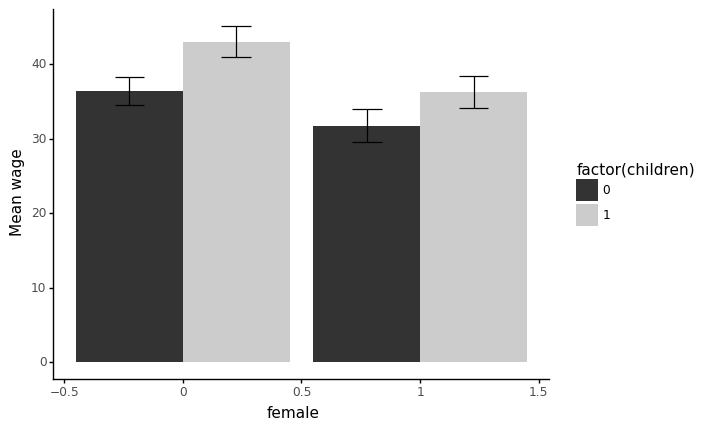

<ggplot: (156956897247)>

In [196]:
# Interaction 4 - female*children
price_diff_by_variables(df_final,"female","children")